In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms

In [2]:
print(torch.__version__)

1.13.0.dev20220624


In [3]:
input_size = 784 # 28x28
hidden_layer1= 500 
hidden_layer2=250
hidden_layer3=100
num_classes = 10
num_epochs = 15
batch_size = 64
learning_rate = 0.01


In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(),  download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

In [5]:
def convert_to_onehot(labels,num_classes):
    output = np.eye(num_classes)[np.array(labels).reshape(-1)]
    return output.reshape(list(np.shape(labels))+[num_classes])

In [6]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    return np.exp(x)/sum(np.exp(x))



In [7]:
def sigmoid_derivative(x):
    return sigmoid(x) * (1- sigmoid(x))

def relu_derivative(x):
    return x>0

def softmax_derivative(x):

    return softmax(x)*(1-softmax(x))

In [8]:

def init_weights(No,Ni):
    M=np.sqrt(6/(Ni+No))
    weights=np.asarray(np.random.uniform(-M, M, (No, Ni)), dtype=np.float64)
    biases  = np.zeros((No,1))
    return weights,biases

In [9]:
def initialize_parameters(layers_dims):
    w1,b1=init_weights(layers_dims[1],layers_dims[0])
    w2,b2=init_weights(layers_dims[2],layers_dims[1])
    w3,b3=init_weights(layers_dims[3],layers_dims[2])
    w4,b4=init_weights(layers_dims[4],layers_dims[3])
    parameters={
    "w1":w1,
    "w2":w2,
    "w3":w3,
    "w4":w4,
    "b1":b1,
    "b2":b2,
    "b3":b3,
    "b4":b4
    }
    return parameters

In [10]:
def forward_propagation(X,parameters):
    w1=parameters['w1']
    b1=parameters['b1']
    w2=parameters['w2']
    b2=parameters['b2']
    w3=parameters['w3']
    b3=parameters['b3']
    w4=parameters['w4']
    b4=parameters['b4']
    Z1=np.dot(w1,X.T)+b1
    A1=relu(Z1)
    Z2 = np.dot(w2,A1) + b2
    A2=relu(Z2)
    Z3 = np.dot(w3,A2) + b3
    A3=relu(Z3)
    Z4=np.dot(w4,A3)+b4
    A4=softmax(Z4)
    cache = {
        "Z1" : Z1,
        "Z2" : Z2,
        "Z3" : Z3,
        "Z4" : Z4,
        "A1" : A1,
        "A2" : A2,
        "A3" : A3,
        "A4" : A4,
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2,
        "w3" : w3,
        "b3" : b3,
        "w4" : w4,
        "b4" : b4  
    }
    return A4,cache

In [11]:
def compute_cost(A, Y):    
    #A is predicted
    #Y is actual
    m = Y.shape[1] 
    logprobs = np.multiply(-np.log(A),Y) + np.multiply(-np.log(1 - A), 1 - Y)
    cost = 1./m * np.nansum(logprobs)
    return cost

In [12]:
def backward_propagation(X, Y, cache):
    m = X.shape[1]
    A4=cache['A4']
    A3=cache['A3']
    A2=cache['A2']
    A1=cache['A1']
    Z3=cache['Z3']
    Z4=cache['Z4']
    Z2=cache['Z2']
    Z1=cache['Z1']
    w1=cache['w1']
    b1=cache['b1']
    w2=cache['w2']
    b2=cache['b2']
    w3=cache['w3']
    b3=cache['b3']
    w4=cache['w4']
    b4=cache['b4']

    dZ4 = A4 - Y
    dW4 = 1./m * np.dot(dZ4, A3.T)
    db4 = 1./m * np.sum(dZ4, axis=1, keepdims = True)
    
    dA3 = np.dot(w4.T, dZ4)
    dZ3 = np.multiply(dA3, np.int64(A3 > 0))
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(w3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)

    dA1 = np.dot(w2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)

    
    gradients = {"dZ4": dZ4, "dW4": dW4, "db4": db4,
                 "dA3": dA3, "dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [13]:
def update_parameter(parameters,gradients,learning_rate):
    w1=parameters['w1']
    b1=parameters['b1']
    w2=parameters['w2']
    b2=parameters['b2']
    w3=parameters['w3']
    b3=parameters['b3']
    w4=parameters['w4']
    b4=parameters['b4']
    dW1=gradients['dW1']
    db1=gradients['db1']
    dW2=gradients['dW2']
    db2=gradients['db2']
    dW3=gradients['dW3']
    db3=gradients['db3']
    dW4=gradients['dW4']
    db4=gradients['db4']
    w1 = w1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    w2 = w2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    w3 = w3 - learning_rate * dW3
    b3 = b3 - learning_rate * db3
    w4 = w4 - learning_rate * dW4
    b4 = b4 - learning_rate * db4
    
    updated_parameters={
    "w1":w1,
    "w2":w2,
    "w3":w3,
    "w4":w4,
    "b1":b1,
    "b2":b2,
    "b3":b3,
    "b4":b4
    }
    return updated_parameters

In [14]:
def find_accuracy(y_actual,y_pred):
    accuracy = np.count_nonzero(np.argmax(y_pred,axis=0)==np.argmax(y_actual,axis=1))/y_actual.shape[0]
    return accuracy

In [15]:
def predict(X,Y,parameters):
    y_pred,cache=forward_propagation(X,parameters)
    return y_pred

In [16]:
def model1(dataset,layers_dims,num_epochs):
    m=len(dataset)
    num_batches=m/batch_size
    parameters=initialize_parameters(layers_dims)
    costs=[]
    acc=[]
    for epoch in range(num_epochs):
        for i in range(int(num_batches)):
            # Data loader
            loader = torch.utils.data.DataLoader(dataset=dataset,batch_size = batch_size ,shuffle=True)
            dataiter = iter(loader)
            data = next(dataiter)
            X,y = data
            X=X.numpy()
            y=y.numpy()
            # Flatten the images
            image_vector_size = 28*28
            X = X.reshape(X.shape[0], image_vector_size)
            y_one_hot=convert_to_onehot(y,num_classes)
            y_pred,cache=forward_propagation(X,parameters)
            cost=compute_cost(y_pred,y_one_hot.T)
            gradients=backward_propagation(X,y_one_hot.T,cache)
            parameters=update_parameter(parameters,gradients,learning_rate)
            if i%20==0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{int(num_batches)}], Loss: {cost.item():.4f}')
                costs.append(cost)
                acc.append(find_accuracy(y_one_hot,y_pred))
    return acc,costs,parameters



In [17]:
layers_dims=[784,500,250,100,10]
train_acc,train_costs,trained_parameters=model1(train_dataset,layers_dims,15)

Epoch [1/15], Step [1/937], Loss: 3.3070
Epoch [1/15], Step [21/937], Loss: 3.3930
Epoch [1/15], Step [41/937], Loss: 3.3383
Epoch [1/15], Step [61/937], Loss: 3.2674
Epoch [1/15], Step [81/937], Loss: 3.2791
Epoch [1/15], Step [101/937], Loss: 3.2833
Epoch [1/15], Step [121/937], Loss: 3.2853
Epoch [1/15], Step [141/937], Loss: 3.2335
Epoch [1/15], Step [161/937], Loss: 3.2185
Epoch [1/15], Step [181/937], Loss: 3.2498
Epoch [1/15], Step [201/937], Loss: 3.2284
Epoch [1/15], Step [221/937], Loss: 3.2267
Epoch [1/15], Step [241/937], Loss: 3.2392
Epoch [1/15], Step [261/937], Loss: 3.2338
Epoch [1/15], Step [281/937], Loss: 3.1564
Epoch [1/15], Step [301/937], Loss: 3.1907
Epoch [1/15], Step [321/937], Loss: 3.1629
Epoch [1/15], Step [341/937], Loss: 3.1579
Epoch [1/15], Step [361/937], Loss: 3.1560
Epoch [1/15], Step [381/937], Loss: 3.1555
Epoch [1/15], Step [401/937], Loss: 3.1542
Epoch [1/15], Step [421/937], Loss: 3.1088
Epoch [1/15], Step [441/937], Loss: 3.1181
Epoch [1/15], Ste

Epoch [5/15], Step [81/937], Loss: 1.2027
Epoch [5/15], Step [101/937], Loss: 1.1762
Epoch [5/15], Step [121/937], Loss: 1.1519
Epoch [5/15], Step [141/937], Loss: 1.3229
Epoch [5/15], Step [161/937], Loss: 1.1102
Epoch [5/15], Step [181/937], Loss: 1.2696
Epoch [5/15], Step [201/937], Loss: 1.1507
Epoch [5/15], Step [221/937], Loss: 1.2965
Epoch [5/15], Step [241/937], Loss: 1.0980
Epoch [5/15], Step [261/937], Loss: 1.1042
Epoch [5/15], Step [281/937], Loss: 1.1245
Epoch [5/15], Step [301/937], Loss: 1.1879
Epoch [5/15], Step [321/937], Loss: 1.3391
Epoch [5/15], Step [341/937], Loss: 1.1032
Epoch [5/15], Step [361/937], Loss: 1.2335
Epoch [5/15], Step [381/937], Loss: 1.0489
Epoch [5/15], Step [401/937], Loss: 1.3224
Epoch [5/15], Step [421/937], Loss: 1.2749
Epoch [5/15], Step [441/937], Loss: 1.1017
Epoch [5/15], Step [461/937], Loss: 1.2538
Epoch [5/15], Step [481/937], Loss: 0.8803
Epoch [5/15], Step [501/937], Loss: 0.9185
Epoch [5/15], Step [521/937], Loss: 1.1503
Epoch [5/15]

Epoch [9/15], Step [161/937], Loss: 0.5916
Epoch [9/15], Step [181/937], Loss: 0.5295
Epoch [9/15], Step [201/937], Loss: 0.7225
Epoch [9/15], Step [221/937], Loss: 0.8483
Epoch [9/15], Step [241/937], Loss: 0.6742
Epoch [9/15], Step [261/937], Loss: 0.6787
Epoch [9/15], Step [281/937], Loss: 0.6248
Epoch [9/15], Step [301/937], Loss: 0.8634
Epoch [9/15], Step [321/937], Loss: 0.8111
Epoch [9/15], Step [341/937], Loss: 0.6993
Epoch [9/15], Step [361/937], Loss: 0.6606
Epoch [9/15], Step [381/937], Loss: 0.7321
Epoch [9/15], Step [401/937], Loss: 0.6036
Epoch [9/15], Step [421/937], Loss: 0.6619
Epoch [9/15], Step [441/937], Loss: 0.6192
Epoch [9/15], Step [461/937], Loss: 0.9491
Epoch [9/15], Step [481/937], Loss: 0.5904
Epoch [9/15], Step [501/937], Loss: 0.5836
Epoch [9/15], Step [521/937], Loss: 0.7370
Epoch [9/15], Step [541/937], Loss: 0.7767
Epoch [9/15], Step [561/937], Loss: 0.8180
Epoch [9/15], Step [581/937], Loss: 0.5443
Epoch [9/15], Step [601/937], Loss: 0.6822
Epoch [9/15

Epoch [13/15], Step [161/937], Loss: 0.5276
Epoch [13/15], Step [181/937], Loss: 0.4035
Epoch [13/15], Step [201/937], Loss: 0.4663
Epoch [13/15], Step [221/937], Loss: 0.3708
Epoch [13/15], Step [241/937], Loss: 0.5209
Epoch [13/15], Step [261/937], Loss: 0.4217
Epoch [13/15], Step [281/937], Loss: 0.5159
Epoch [13/15], Step [301/937], Loss: 0.6549
Epoch [13/15], Step [321/937], Loss: 0.7862
Epoch [13/15], Step [341/937], Loss: 0.6749
Epoch [13/15], Step [361/937], Loss: 0.4374
Epoch [13/15], Step [381/937], Loss: 0.4583
Epoch [13/15], Step [401/937], Loss: 0.6113
Epoch [13/15], Step [421/937], Loss: 0.5512
Epoch [13/15], Step [441/937], Loss: 0.6851
Epoch [13/15], Step [461/937], Loss: 0.5315
Epoch [13/15], Step [481/937], Loss: 0.4887
Epoch [13/15], Step [501/937], Loss: 0.5723
Epoch [13/15], Step [521/937], Loss: 0.6070
Epoch [13/15], Step [541/937], Loss: 0.5203
Epoch [13/15], Step [561/937], Loss: 0.5838
Epoch [13/15], Step [581/937], Loss: 0.7397
Epoch [13/15], Step [601/937], L

In [18]:
p=len(test_dataset)
test_batches=p/batch_size
loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size = p ,shuffle=True)
dataiter = iter(loader)
data = next(dataiter)
X,y = data

X=X.numpy()
y=y.numpy()
# Flatten the images
image_vector_size = 28*28
X = X.reshape(X.shape[0], image_vector_size)
y_one_hot=convert_to_onehot(y,num_classes)
y_hat,out_cache=forward_propagation(X,trained_parameters)

test_accuracy=find_accuracy(y_one_hot,y_hat)
test_cost=compute_cost(y_hat,y_one_hot.T)

Text(51.0, 0.5, 'truth')

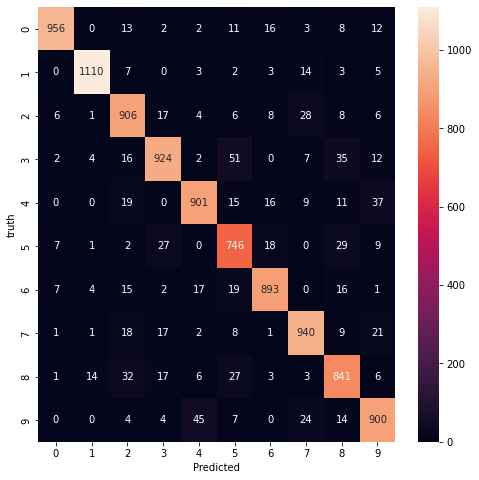

In [19]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
k = np.argmax(y_hat,axis=0)
cm=confusion_matrix(k, y)
plt.figure(figsize=(8,8))
sn.heatmap(confusion_matrix(k, y),annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('truth')

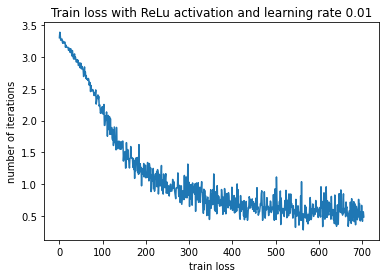

In [20]:
plt.plot(train_costs)
plt.xlabel('train loss')
plt.ylabel('number of iterations')
plt.title('Train loss with ReLu activation and learning rate 0.01')
plt.show()

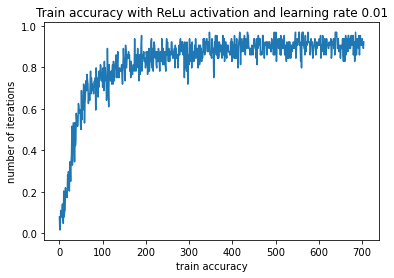

In [26]:
plt.plot(train_acc)
plt.xlabel('train accuracy')
plt.ylabel('number of iterations')
plt.title('Train accuracy with ReLu activation and learning rate 0.01')
plt.show()

In [22]:
m=len(train_dataset)
train_batches=m/batch_size
loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size = m ,shuffle=True)
dataiter = iter(loader)
data = next(dataiter)
X_train,y_train = data

X_train=X_train.numpy()
y_train=y_train.numpy()
# Flatten the images
image_vector_size = 28*28
X_train = X_train.reshape(X_train.shape[0], image_vector_size)
y_train_one_hot=convert_to_onehot(y_train,num_classes)
y_train_hat,out_train_cache=forward_propagation(X_train,trained_parameters)
train_accuracy_final=find_accuracy(y_train_one_hot,y_train_hat)
train_cost_final=compute_cost(y_train_hat,y_train_one_hot.T)

In [23]:
print(train_accuracy_final)

0.90805


In [24]:
print(train_acc[-1])

0.921875


In [25]:
print(test_accuracy)

0.9117
